In [34]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from matplotlib import offsetbox
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
import scipy as sc
import pandas as pd


2.7.0


In [7]:
image_paths = glob.glob('/Users/wangcong/workspace/NEU/INFO7374/FashionData/CDM/imagesub/*.jpg')
print(f'Found [{len(image_paths)}] images')

Found [66] images


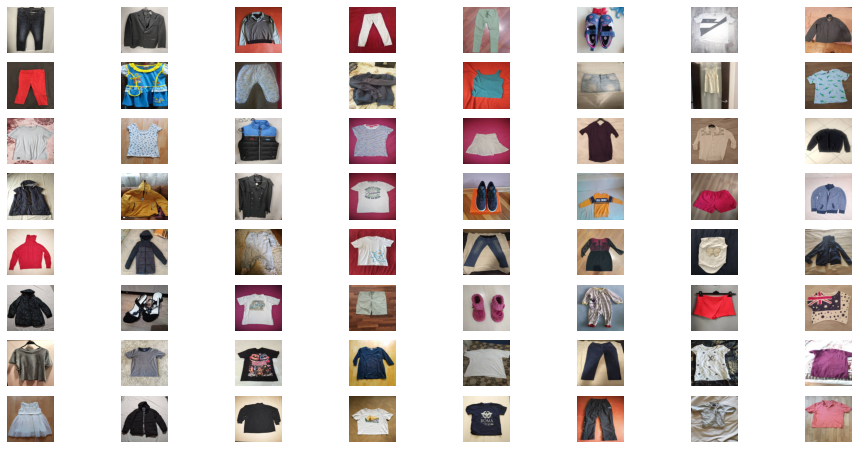

In [8]:
# image_paths = glob.glob('/Users/wangcong/workspace/NEU/INFO7374/FashionData/CDM')
# print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [9]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

#
# content layers describe the image subject
#
content_layers = ['block5_conv2'] 

#
# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
#
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model


In [10]:
# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


In [11]:
class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
    
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 

#
# Print shapes of the style layers and embeddings
#
image_tensor = load_image(image_paths[0])
style_tensors = image_to_style(image_tensor)
for k,v in style_tensors.items():
    print(f'Style tensor {k}: {v.shape}')
style_embedding = style_to_vec( style_tensors )
print(f'Style embedding: {style_embedding.shape}')

#
# compute styles
#
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

80150528/80134624 [==============================] - 8s 0us/step
Style tensor block1_conv1: (1, 64, 64)
Style tensor block2_conv1: (1, 128, 128)
Style tensor block3_conv1: (1, 256, 256)
Style embedding: (86016,)


100%|██████████| 66/66 [00:39<00:00,  1.69it/s]


In [12]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

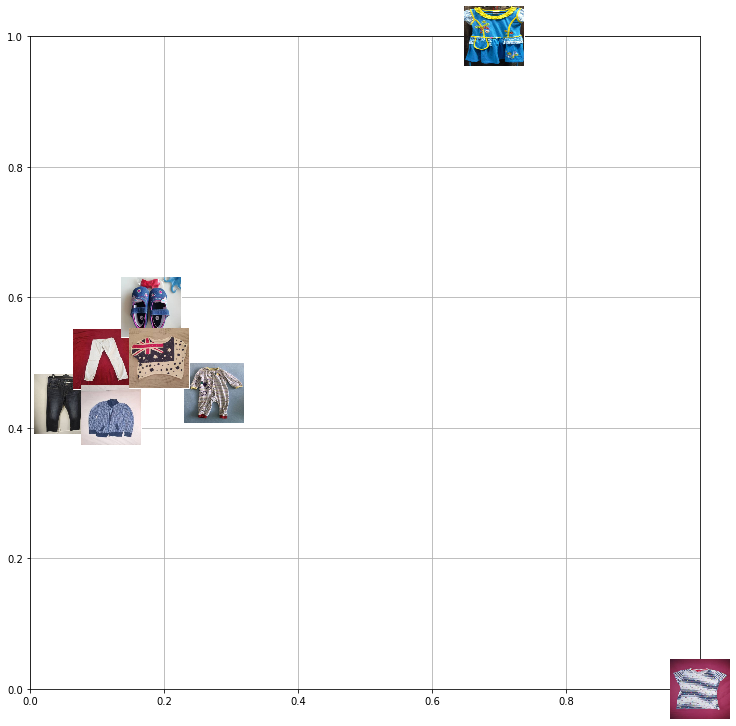

In [13]:
#
# Visualize the 2D-projection of the embedding space with example images (thumbnails)
#
def embedding_plot(X, images, thumbnail_sparsity = 0.005, thumbnail_size = 0.3):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig, ax = plt.subplots(1, figsize=(12, 12))

    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        if np.min(np.sum((X[i] - shown_images) ** 2, axis=1)) < thumbnail_sparsity: continue
        shown_images = np.r_[shown_images, [X[i]]]
        thumbnail = offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r, zoom=thumbnail_size)
        ax.add_artist(offsetbox.AnnotationBbox(thumbnail, X[i], bboxprops = dict(edgecolor='white'), pad=0.0))

    plt.grid(True)
    
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=10, random_state=0)
X_tsne = tsne.fit_transform( np.array(list(image_style_embeddings.values())) )
embedding_plot(X_tsne, images=list(images.values()))

('0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg', 0.0)
('0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg', 0.05968588590621948)
('0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg', 0.08711713552474976)
('0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg', 0.10724741220474243)
('0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg', 0.11660784482955933)
('0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg', 0.11990272998809814)
('0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg', 0.1260976791381836)
('0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg', 0.13837957382202148)
('0add1694-17d0-46ec-a9fc-900da252af41.jpg', 0.14862388372421265)
('0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg', 0.15469127893447876)


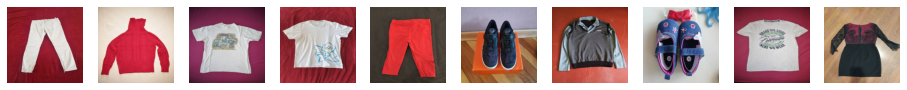

['0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg',
 '0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg',
 '0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg',
 '0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg',
 '0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg',
 '0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg',
 '0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg',
 '0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg',
 '0add1694-17d0-46ec-a9fc-900da252af41.jpg',
 '0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg']

In [21]:
def search_by_style(image_style_embeddings, images, reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    img_list = []
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        #print(i)
        print(img)
        img_list.append(img[0])
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()

    plt.show()
    return img_list

# images mostly match the reference style, although not perfectly
search_by_style(image_style_embeddings, images, '0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg')
#search_by_style(image_style_embeddings, images, '0a904aee-7ee6-41db-bb7f-97e991c6a994.jpg')

In [29]:
def search_by_style_name(image_style_embeddings, images, reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    img_list = []
    #f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        #print(i)
        #print(img)
        img_list.append(img[0])
        
    return img_list


In [31]:
img_list = search_by_style_name(image_style_embeddings, images, '0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg')
img_list

['0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg',
 '0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg',
 '0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg',
 '0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg',
 '0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg',
 '0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg',
 '0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg',
 '0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg',
 '0add1694-17d0-46ec-a9fc-900da252af41.jpg',
 '0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg']

In [35]:
a=[img_list]
result = pd.DataFrame(a)
result

,0,1,2,3,4,5,6,7,8,9
0,0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg,0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg,0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg,0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg,0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg,0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg,0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg,0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg,0add1694-17d0-46ec-a9fc-900da252af41.jpg,0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg


In [38]:
img_list=[]
for img in images:
    img_list_each = search_by_style_name(image_style_embeddings, images, img, max_results=10)
    img_list.append(img_list_each)

img_list

[['0c224954-0e0f-4caa-82c8-cf9581e89336.jpg',
  '0cb3a527-be77-4ba9-9430-c097a45d4db5.jpg',
  '00b8048d-635e-4e56-b182-071fb24eea32.jpg',
  '0ccc318a-7d69-4d7f-a442-aac1f88bc453.jpg',
  '0c7412e7-81eb-40b7-be64-ce9782103529.jpg',
  '0b7f4987-34e4-4c85-9f28-35e04ae78ece.jpg',
  '0a69db60-c052-4b9a-a90d-e53120d091d5.jpg',
  '0bd7a506-9042-4dfc-b061-0a8279c887bb.jpg',
  '00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg',
  '00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa.jpg'],
 ['00b8048d-635e-4e56-b182-071fb24eea32.jpg',
  '0cb3a527-be77-4ba9-9430-c097a45d4db5.jpg',
  '0c224954-0e0f-4caa-82c8-cf9581e89336.jpg',
  '0cb4fc9c-7d38-4f11-95ea-71b61d0ae54c.jpg',
  '0ccc318a-7d69-4d7f-a442-aac1f88bc453.jpg',
  '00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa.jpg',
  '00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg',
  '0bd7a506-9042-4dfc-b061-0a8279c887bb.jpg',
  '0b7f4987-34e4-4c85-9f28-35e04ae78ece.jpg',
  '00a1b7a8-217d-45bf-93a8-86db0bdf9d9d.jpg'],
 ['0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg',
  '0c2eb9ff-7f26-492d-9957-0d845

In [40]:
b = img_list
result_final = pd.DataFrame(b)
result_final

,0,1,2,3,4,5,6,7,8,9
0,0c224954-0e0f-4caa-82c8-cf9581e89336.jpg,0cb3a527-be77-4ba9-9430-c097a45d4db5.jpg,00b8048d-635e-4e56-b182-071fb24eea32.jpg,0ccc318a-7d69-4d7f-a442-aac1f88bc453.jpg,0c7412e7-81eb-40b7-be64-ce9782103529.jpg,0b7f4987-34e4-4c85-9f28-35e04ae78ece.jpg,0a69db60-c052-4b9a-a90d-e53120d091d5.jpg,0bd7a506-9042-4dfc-b061-0a8279c887bb.jpg,00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg,00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa.jpg
1,00b8048d-635e-4e56-b182-071fb24eea32.jpg,0cb3a527-be77-4ba9-9430-c097a45d4db5.jpg,0c224954-0e0f-4caa-82c8-cf9581e89336.jpg,0cb4fc9c-7d38-4f11-95ea-71b61d0ae54c.jpg,0ccc318a-7d69-4d7f-a442-aac1f88bc453.jpg,00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa.jpg,00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg,0bd7a506-9042-4dfc-b061-0a8279c887bb.jpg,0b7f4987-34e4-4c85-9f28-35e04ae78ece.jpg,00a1b7a8-217d-45bf-93a8-86db0bdf9d9d.jpg
2,0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg,0c2eb9ff-7f26-492d-9957-0d845669685f.jpg,0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg,0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg,0a2668d3-e42a-4f46-bb7f-01cc409c1839.jpg,0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg,0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg,0b546ee0-81f3-4d93-938d-34166d4194d7.jpg,0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg,00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg
3,0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg,0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg,0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg,0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg,0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg,0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg,0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg,0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg,0add1694-17d0-46ec-a9fc-900da252af41.jpg,0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg
4,0c99f0b4-3a0d-4d24-bfdd-e9e98914892c.jpg,0ca7f456-e16e-4afe-ab4e-9639719ec0b5.jpg,0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg,0cab4de0-5818-4680-a00a-35dbc6e95525.jpg,0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg,0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg,0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg,0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg,0a2668d3-e42a-4f46-bb7f-01cc409c1839.jpg,0c2eb9ff-7f26-492d-9957-0d845669685f.jpg
...,...,...,...,...,...,...,...,...,...,...
61,0c2eb9ff-7f26-492d-9957-0d845669685f.jpg,0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg,0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg,0b546ee0-81f3-4d93-938d-34166d4194d7.jpg,0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg,0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg,0a2668d3-e42a-4f46-bb7f-01cc409c1839.jpg,00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg,0bad128f-51d3-4f15-9213-0856d8bac797.jpg,0cab4de0-5818-4680-a00a-35dbc6e95525.jpg
62,0cd501af-4cce-460d-9431-637bf0d95499.jpg,0c6472ac-e3f8-443b-a884-2e60562c35b1.jpg,0b0457d9-32f9-4b34-915d-017e5525d9f6.jpg,0bdfdcd8-8ca7-410b-8e92-d47ff1aa5546.jpg,0d0c2308-2c58-4e38-90c1-c893358b5f86.jpg,0af4203f-8998-4719-92fe-65c14a6b6093.jpg,0b20fabe-a5f2-4549-bbb2-504ee53dc89d.jpg,0c6f89cd-30f6-4b44-bda5-0ba8d90e6717.jpg,0c7412e7-81eb-40b7-be64-ce9782103529.jpg,0cb83705-48f5-42f4-9288-cd7d11cb77c5.jpg
63,0cab4de0-5818-4680-a00a-35dbc6e95525.jpg,0ba2d892-a1fb-4961-88a8-d77875b9f673.jpg,0b20fabe-a5f2-4549-bbb2-504ee53dc89d.jpg,0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg,0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg,0ca7f456-e16e-4afe-ab4e-9639719ec0b5.jpg,0c99f0b4-3a0d-4d24-bfdd-e9e98914892c.jpg,0aa095c3-9d4d-4416-8788-82655af859a8.jpg,0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg,0c2eb9ff-7f26-492d-9957-0d845669685f.jpg
64,0d0c2308-2c58-4e38-90c1-c893358b5f86.jpg,0bdfdcd8-8ca7-410b-8e92-d47ff1aa5546.jpg,0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg,0c6472ac-e3f8-443b-a884-2e60562c35b1.jpg,0cb83705-48f5-42f4-9288-cd7d11cb77c5.jpg,00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg,0cb4fc9c-7d38-4f11-95ea-71b61d0ae54c.jpg,0af4203f-8998-4719-92fe-65c14a6b6093.jpg,0c7e73b3-af7e-4b6c-b142-82a3760114c3.jpg,0c6f89cd-30f6-4b44-bda5-0ba8d90e6717.jpg


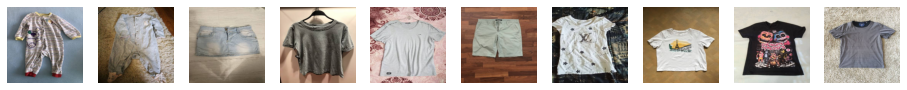

In [16]:
search_by_style(image_style_embeddings, images, '0a904aee-7ee6-41db-bb7f-97e991c6a994.jpg')

In [41]:
import json

In [42]:
result_json = result_final.to_json(orient="index")
parsed = json.loads(result_json)
json.dumps(parsed, indent=4)

'{\n    "0": {\n        "0": "0c224954-0e0f-4caa-82c8-cf9581e89336.jpg",\n        "1": "0cb3a527-be77-4ba9-9430-c097a45d4db5.jpg",\n        "2": "00b8048d-635e-4e56-b182-071fb24eea32.jpg",\n        "3": "0ccc318a-7d69-4d7f-a442-aac1f88bc453.jpg",\n        "4": "0c7412e7-81eb-40b7-be64-ce9782103529.jpg",\n        "5": "0b7f4987-34e4-4c85-9f28-35e04ae78ece.jpg",\n        "6": "0a69db60-c052-4b9a-a90d-e53120d091d5.jpg",\n        "7": "0bd7a506-9042-4dfc-b061-0a8279c887bb.jpg",\n        "8": "00bede7c-eae4-4ee9-a1ac-1721b3f94c54.jpg",\n        "9": "00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa.jpg"\n    },\n    "1": {\n        "0": "00b8048d-635e-4e56-b182-071fb24eea32.jpg",\n        "1": "0cb3a527-be77-4ba9-9430-c097a45d4db5.jpg",\n        "2": "0c224954-0e0f-4caa-82c8-cf9581e89336.jpg",\n        "3": "0cb4fc9c-7d38-4f11-95ea-71b61d0ae54c.jpg",\n        "4": "0ccc318a-7d69-4d7f-a442-aac1f88bc453.jpg",\n        "5": "00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa.jpg",\n        "6": "00bede7c-eae4-4ee9-a1ac

In [43]:
b = json.dumps(parsed, indent=4)
f = open('new_json.json','w')
f.write(b)
f.close()

In [ ]:
curl -H "Content-Type: application/x-ndjson"  -s -XPOST "localhost:9200/_bulk?pretty&refresh" --data-binary "@E:\files\es_zeusa.evony.com.accesslog\test.json"
